In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pdb
from scipy.optimize import curve_fit
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from jupyter.Sinead.synthetic_dag import DAG

Implement the following generative model:

$$\begin{aligned}
\texttt{nationality} \sim& \mbox{Categorical}(\texttt{natProps})\\
\texttt{isMale} | \texttt{nationality} = n \sim& \mbox{Bernoulli}(\texttt{probMale}_n)\\
\texttt{age}|\texttt{isMale}=m \sim& \mbox{Poisson}(\texttt{lambdaAge}_{m})\\
% \texttt{race} \sim& \mbox{Categorical}(\texttt{nationality}\cdot \texttt{raceProps} )\\
\texttt{isMarried} |\texttt{age} = a, \texttt{isMale} = m \sim& \mbox{Bernoulli}(\sigma(f_{m}(a))\\
\texttt{latentFamilySupport} \sim& \mbox{Normal}(0, 1)\\
\texttt{latentPrivilege} \sim& \mbox{Normal}(\texttt{nationality} \cdot  \texttt{natPriv} + \texttt{isMale} \cdot \texttt{malePriv} + 0.2 \,\texttt{latentFamilySupport}, 1)\\
\texttt{bmi} \sim& \mbox{Poisson}(25 + 0.2 \times max(\texttt{age}-25, 0) + \texttt{isMale} - 0.05 \, \texttt{latentFamilySupport})\\
\texttt{smokes} \sim& \mbox{Bernoulli}(0.5\Phi(\texttt{latentFamilySupport}) + 0.2\texttt{isMale} +0.003*\texttt{age})\\
\texttt{graduatedHighSchool} \sim& \mbox{Bernoulli}(g_1(\texttt{age}, \texttt{isMale}, \texttt{latentPrivilege}))\\
\texttt{somePostSecondary} \sim& \mbox{Bernoulli}(g_2(\texttt{age}, \texttt{isMale}, \texttt{latentPrivilege}, \texttt{graduatedHighSchool}))\\
\texttt{postSecondaryDegree} \sim& \mbox{Bernoulli}(g_3(\texttt{age}, \texttt{isMale}, \texttt{latentPrivilege}, \texttt{somePostSecondary}))\\
\texttt{education} =& \texttt{toOneHot}(\texttt{graduatedHighSchool}, \texttt{somePostSecondary}, \texttt{postSecondaryDegree}))\\
\texttt{industry}|\texttt{education}=e, \texttt{isMale}=m\sim& \mbox{Categorical}(\texttt{industryProbs}_{e, m})\\
\texttt{isUnemployed}\sim&\mbox{Bernoulli}(\texttt{clipTo01}(0.01(22-0.9\texttt{age} + 0.01\texttt{age}^2 + \texttt{isMale} \\
& \qquad \qquad \qquad +\texttt{isMarried}(1-\texttt{isMale}) -0.5*\texttt{latentPrivilege})))\\
\texttt{salaryLatent}|\texttt{isMale}=m, \texttt{industry}=i \sim& \mbox{Gaussian}(\texttt{industryMean}_{m, i} \\
& \qquad \qquad + (\texttt{age}-35)\texttt{industryAgeSlope}_i + \texttt{postSecondaryDegree}\cdot\texttt{industryDegreeBoost}_i \\
& \qquad \qquad + \texttt{latentPrivilege}\cdot \texttt{industryPrivilegeBoost}, 500^2)\\
\texttt{salary} =& (1-\texttt{isUnemployed}) \cdot \texttt{salaryLatent}
\end{aligned}$$

## Parameters and notes:

All tables referenced are from https://www.censtatd.gov.hk/hkstat/sub/gender/employment_earnings
* $\texttt{natProps}$: proportions based on Table 1.10 Population by Nationality and Sex, combined for all genders. Nationalities: Chinese (HK), Chinese (other), Filipino, Indonesian, British, Indian, Nepalese, Pakistani, American, Australian, Thai, Japanese, Other
* $\texttt{probMale}$: proportions based on Table 1.10 Population by Nationality and Sex
* $\texttt{lambdaAge}$: calculated from the median ages in Table 1.3, using the approximate relationship between the parameter of a Poisson and the median. Note, Poisson is a bad fit here, need to change later
* $\texttt{isMarried}$: estimated from table 2.1 Population aged 15 and over by marital status, age group and sex. To get the parameters, I fit a sigmoid to the data (using the mean age for each group as the x value, and excluding $\geq$ 65 as it is an undefined range.
* $\texttt{latentFamilySupport}$: I'm envisaging as a latent variable of how supportive your family was
* $\texttt{latentPrivilege}$: A latent variable of how much privilege you have. $\texttt{natPriv}$ and $\texttt{malePriv}$ were hand-designed by me to capture different privileges by race and gender (note, I'm using nationality as a proxy for gender here, should probably have used ethnicity not nationality)
* $\texttt{bmi}$: This is entirely hand-specified, under the assumption that BMI increases with age and decreases with supportive family for example.
* $\texttt{smokes}$: Again, hand-crafted based on semi-realistic assumptions
* $\texttt{graduatedHighSchool}$: proportion who have graduated high school (ie max educational achievement is Upper Secondary, Post Secondary Nondegree, or Post Secondary Degree), based on Table 3.3A (note, this excludes foreign domestic helpers) for M/F. To get the parameters, transformed the probabilities to logits, and fit a quadratic function. I then added noise to the estimates based on latent privilege, and transformed back to probabilities -- to capture the fact that more privileged individuals are more likely to graduate. Deterministically set to zero for under 15 year olds.
* $\texttt{somePostSecondary}$: probabilty of having some post secondary eductation, conditioned on having graduated highschool -- based on (Post Secondary Nondegree + Post Secondary Degree)/(Upper Secondary + Post Secondary Nondegree + Post Secondary Degree). Same process as high school, slightly higher privilege component.
* $\texttt{postSecondaryDegree}$: probability of having a post-secondary degree, conditioned on having some post-secondary -- same process as $\texttt{somePostSecondary}$
* $\texttt{education}$ is a summary of the previous education variables. Note, this isn't explicitly implemented, I leave them as binaries.
* $\texttt{industry}$ is $P(\texttt{industry}|\texttt{education}, \texttt{gender})$ from table 4.21: Employed persons by industry, educational attainment and sex. Note there are more tables that include things like age etc, could construct something that depends on that at a later point.
* $\texttt{isUnemployed}$ is loosely inspired by fitting a quadratic to the unemployment numbers in table 4.3: Unemployment rate by age group and sex, with heuristic add-ons to increase probability for men (based on table) and married women (based on intuition) and privilege.
* $\texttt{salary}$: Starts with means for each group based on Table 5.5 Median monthly employment earnings of employed persons by industry and sex. Then adds hand-crafted offsets for education, age, privilege. Note I haven't checked the final histograms yet for each industry. Ideally, this should be something heavier tailed -- maybe a Laplace? (not implemented yet)

Not done yet: 
* $\texttt{housingBudget}|\texttt{salary}, \texttt{latentFamilySupport}, \texttt{isMarried}$
* $\texttt{district}|\texttt{housingBudget}, \texttt{nationality}, \texttt{latentPrivilege}$
* ...

In [2]:
# a hot mess of code implementing the above parameters/functions

natProps = [0.906, 0.017, 0.025, 0.022, 0.005, 0.004, 0.004, 0.002, 0.002, 0.002, 0.002, 0.001, 0.001]
natProps = [n/np.sum(natProps) for n in natProps]
# nationalities: Chinese (HK), Chinese (other), Filipino, Indonesian, British, Indian, Nepalese, Pakistani, American, Australian, Thai, Japanese, Other)

natPriv = [1., 1., -1., -0.5, 2., -0.5, -0.5, -0.5, 2., 2., 0., 0., 0.]

probMale = [0.48, 0.40, 0.06, 0.02, 0.62, 0.48, 0.52, 0.58, 0.58, 0.55, 0.13, 0.51, 0.51]
malePriv = 0.5

medianAge = [44.1, 44.4]
def get_lambda_from_median(median):
    a = 1.
    b = 1./3. - median
    c = -0.02
    lamb = (-b + np.sqrt(b**2 - 4*a*c))/(2*a)
    return lamb
            
lambdaAge = [get_lambda_from_median(age) for age in medianAge]


married_prop_f = [0, 0.045078197, 0.259955752, 0.580926594, 0.736653825, 0.737265416, 0.724672229, 0.713159491, 0.712865321, 0.68163852]
married_prop_m = [0, 0.015080113, 0.140611354, 0.450044603, 0.690140845, 0.756709195, 0.780896523, 0.790468986, 0.830078125, 0.845326409]

ages = [17, 22, 27, 32, 37, 42, 47, 52, 57, 62]

def sigmoid(x, L, x0, k):
    y = L / (1 + np.exp(-k*(x-x0)))
    return (y)

p0 = [max(married_prop_f), np.median(ages),1] # this is an mandatory initial guess

married_params_female, _ = curve_fit(sigmoid, ages, married_prop_f,p0, method='dogbox')
married_params_male, _ = curve_fit(sigmoid, ages, married_prop_m,p0, method='dogbox')

def get_prob_married(age, is_male):
    
    married_params = is_male[:, np.newaxis] * married_params_male + (1-is_male[:, np.newaxis]) * married_params_female
    prob = sigmoid(age, married_params[:, 0], married_params[:, 1], married_params[:, 2])
    return prob
    
ages2 = [17, 25, 35, 45, 55]
hs_prop_f = [0.90, 0.96, 0.88, 0.74, 0.60]
hs_prop_m = [0.89, 0.95, 0.89, 0.79, 0.64]
ps_nondegree_f = [0.35, 0.77, 0.61, 0.46, 0.33] #conditioned on hs
ps_nondegree_m = [0.29, 0.73, 0.62, 0.51, 0.41]
ps_degree_f = [0.66, 0.78, 0.82, 0.79, 0.71] # conditioned on nondegree
ps_degree_m = [0.67, 0.74, 0.79, 0.81, 0.76]

hs_logodds_f = [np.log(p/(1-p)) for p in hs_prop_f]
hs_logodds_m = [np.log(p/(1-p)) for p in hs_prop_m]
ps_nd_logodds_f = [np.log(p/(1-p)) for p in ps_nondegree_f]
ps_nd_logodds_m = [np.log(p/(1-p)) for p in ps_nondegree_m]
ps_d_logodds_f = [np.log(p/(1-p)) for p in ps_degree_f]
ps_d_logodds_m = [np.log(p/(1-p)) for p in ps_degree_m]

def quadratic(x, a, b, c):
    y = a + b*x + c*x**2
    return y
p0 = [0., 1., 0.]
hs_params_female, _ = curve_fit(quadratic, ages2, hs_logodds_f, p0, method='dogbox')
hs_params_male, _ = curve_fit(quadratic, ages2, hs_logodds_m, p0, method='dogbox')
ps_nondegree_params_female, _ = curve_fit(quadratic, ages2, ps_nd_logodds_f, p0, method='dogbox')
ps_nondegree_params_male, _ = curve_fit(quadratic, ages2, ps_nd_logodds_m, p0, method='dogbox')
ps_degree_params_female, _ = curve_fit(quadratic, ages2, ps_d_logodds_f, p0, method='dogbox')
ps_degree_params_male, _ = curve_fit(quadratic, ages2, ps_d_logodds_m, p0, method='dogbox')

def get_hs(age, is_male, latent_privilege):
    hs_params = is_male[:, np.newaxis] * hs_params_male + (1-is_male[:, np.newaxis]) * hs_params_female
    hs_logit = quadratic(age, hs_params[:, 0], hs_params[:, 1], hs_params[:, 2]) + 0.2*latent_privilege
    hs_prob = (age>15) * 1./(1+np.exp(-hs_logit))
    
    return hs_prob

def get_ps_nondegree(age, is_male, has_hs, latent_privilege):
    ps1_params = is_male[:, np.newaxis] * ps_nondegree_params_male + (1-is_male[:, np.newaxis]) * ps_nondegree_params_female
    ps1_logit = quadratic(age, ps1_params[:, 0], ps1_params[:, 1], ps1_params[:, 2]) + 0.3*latent_privilege
    ps1_prob = has_hs/(1+np.exp(-ps1_logit))
    return ps1_prob

def get_ps_degree(age, is_male, has_ps_nondegree, latent_privilege):
    ps2_params = is_male[:, np.newaxis] * ps_degree_params_male + (1-is_male[:, np.newaxis]) * ps_degree_params_female
    ps2_logit = quadratic(age, ps2_params[:, 0], ps2_params[:, 1], ps2_params[:, 2]) + 0.3*latent_privilege
    ps2_prob = has_ps_nondegree/(1+np.exp(-ps2_logit))
    return ps2_prob


# industries are: manufacturing, construction, retail/hospitality, ransport, storage, communications, finance,
# social services, other
industryProbsMale = np.array([[0.08,0.07,0.06,0.08],
                                        [0.24, 0.10, 0.11, 0.09],
                                        [0.25, 0.37, 0.27, 0.44],
                                        [0.21, 0.17, 0.09, 0.12],
                                        [0.09, 0.14, 0.22, 0.12],
                                        [0.12, 0.15, 0.16, 0.12],
                                        [0.01, 0.01, 0.09, 0.02]
                                        ])
industryProbsMale = industryProbsMale / np.sum(industryProbsMale, axis=0)
industryProbsFemale = np.array([[0.08, 0.04, 0.03, 0.03],
                                        [0.01, 0.01, 0.02, 0.01],
                                        [0.40, 0.41, 0.36, 0.22],
                                        [0.03, 0.06, 0.06, 0.06],
                                        [0.06, 0.13, 0.20, 0.25],
                                        [0.41, 0.35, 0.34, 0.43],
                                        [0.01, 0.00, 0.00, 0.00]])
industryProbsFemale = industryProbsFemale / np.sum(industryProbsFemale, axis=0)
def get_industry_probs(isMale, has_hs, has_ps_nondegree, has_ps_degree):
    probs = isMale[:, np.newaxis] * (has_ps_degree[:, np.newaxis] * industryProbsMale[:, 3] \
                      + (1-has_ps_degree[:, np.newaxis]) * has_ps_nondegree[:, np.newaxis] * industryProbsMale[:, 2] \
                      + (1-has_ps_nondegree[:, np.newaxis]) * has_hs[:, np.newaxis] * industryProbsMale[:, 1] \
                      + (1-has_hs[:, np.newaxis]) *  industryProbsMale[:, 0])
    probs += (1 - isMale[:, np.newaxis]) * (has_ps_degree[:, np.newaxis] * industryProbsFemale[:, 3] \
                             + (1-has_ps_degree[:, np.newaxis]) * has_ps_nondegree[:, np.newaxis] * industryProbsFemale[:, 2] \
                             + (1-has_ps_nondegree[:, np.newaxis]) * has_hs[:, np.newaxis]* industryProbsFemale[:, 1] \
                             + (1-has_hs[:, np.newaxis]) *  industryProbsFemale[:, 0])

    return probs


def get_salary_dist(industry, age, latentPrivilege, isMale,  postSecondaryDegree):
    # everything but the means is basically made up
    # should really add on variable std
    industry_means_f = [7500, 9000, 8000, 10800, 14000, 5500, 3400]
    industry_offset_m = [4500, 1000, 4000, -700, 1000, 9500, 5100]
    
    industry_age_slope = [40, 10, 50, 10, 100, 50, 20]
    
    #industry_std = [200, 50, 300, 40, 200, 300, 200]
    industry_degree_boost = [0, 0, 0, 0, 1000, 500, 200]
    industry_privilege_multiplier = [5, 1, 1, 10, 30, 10, 5]
    
    means = np.dot(industry, industry_means_f) + isMale * np.dot(industry, industry_offset_m) 
    means = means + (age-35) * np.dot(industry, industry_age_slope) 
    means = means +  postSecondaryDegree * np.dot(industry, industry_degree_boost)
    
    means = means    + latentPrivilege * np.dot(industry, industry_privilege_multiplier)

    return means
    

In [3]:
# constructing the DAG
dag = DAG()
dag.add_node(node_id=0, node_name='nationality', parents=None, parent_mean_function=natProps, 
             distribution='Categorical'
            )
dag.add_node(node_id=1, node_name='isMale', parents=[0],
             parent_mean_function=lambda x: np.dot(x[0], probMale), distribution='Bernoulli'
            )
dag.add_node(node_id=2, node_name='age', parents=[1],
             parent_mean_function=lambda x: x[0]*lambdaAge[1] + (1-x[0]) * lambdaAge[0], distribution='Poisson'
            ) # need to change this one, Poisson is too light tailed
dag.add_node(node_id=3, node_name='isMarried', parents=[1, 2],
             parent_mean_function = lambda x: get_prob_married(x[1], x[0]), distribution='Bernoulli'
            )
dag.add_node(node_id=4, node_name='latentFamilySupport', parents=None, parent_mean_function=0., 
             distribution='Gaussian', is_latent=True
            )
dag.add_node(node_id=5, node_name='latentPrivilege', parents=[0, 1, 4],
             parent_mean_function = lambda x: np.dot(x[0], natPriv) + np.dot(x[1], malePriv) + 0.2*x[2],
             distribution='Gaussian', is_latent=True
            )
dag.add_node(node_id=6, node_name='bmi', parents=[1, 2, 4],
             parent_mean_function=lambda x: 25 + 0.2*np.maximum(x[1]-25, 0) + x[0] - 0.05*x[2],
             distribution='Poisson'
            ) # made up
dag.add_node(node_id=7, node_name='smokes', parents=[1, 2, 4],
             parent_mean_function=lambda x: 0.5*stats.norm.cdf(x[2]) + 0.2*x[0] + 0.003*x[1],
             distribution='Bernoulli'
            )
dag.add_node(node_id=8, node_name='highSchool', parents=[1, 2, 5],
             parent_mean_function = lambda x: get_hs(x[1], x[0], x[2]), distribution='Bernoulli'
            )
dag.add_node(node_id=9, node_name='somePostSecondary', parents=[1, 2, 5, 8],
            parent_mean_function = lambda x: get_ps_nondegree(x[1], x[0], x[3], x[2]), distribution='Bernoulli'
            )
dag.add_node(node_id=10, node_name='postSecondaryDegree', parents=[1, 2, 5, 9],
            parent_mean_function = lambda x: get_ps_degree(x[1], x[0], x[3], x[2]), distribution='Bernoulli'
            )
dag.add_node(node_id=11, node_name='industry', parents = [1, 8, 9, 10],
            parent_mean_function = lambda x: get_industry_probs(x[0], x[1], x[2], x[3]),
            distribution='Categorical'
            )
dag.add_node(node_id=12, node_name='isUnemployed', parents=[1, 2, 3, 5],
            parent_mean_function=lambda x: np.maximum(0, np.minimum(1, 0.01*(22-0.9*x[1]+0.01*x[1]**2 + x[0] + (1-x[0])*x[2] + 0.5*x[3]))),
             distribution='Bernoulli')
dag.add_node(node_id=13, node_name='salary', parents = [1, 2, 5, 10, 11, 12],
             parent_mean_function = lambda x: get_salary_dist(x[4], x[1], x[2], x[0], x[3]), 
             distribution='Gaussian', std=500, 
             parent_posthoc = lambda x: 1-x[5]
            )

In [4]:
# generate a sample
sample = dag.gen_sample(size=300)


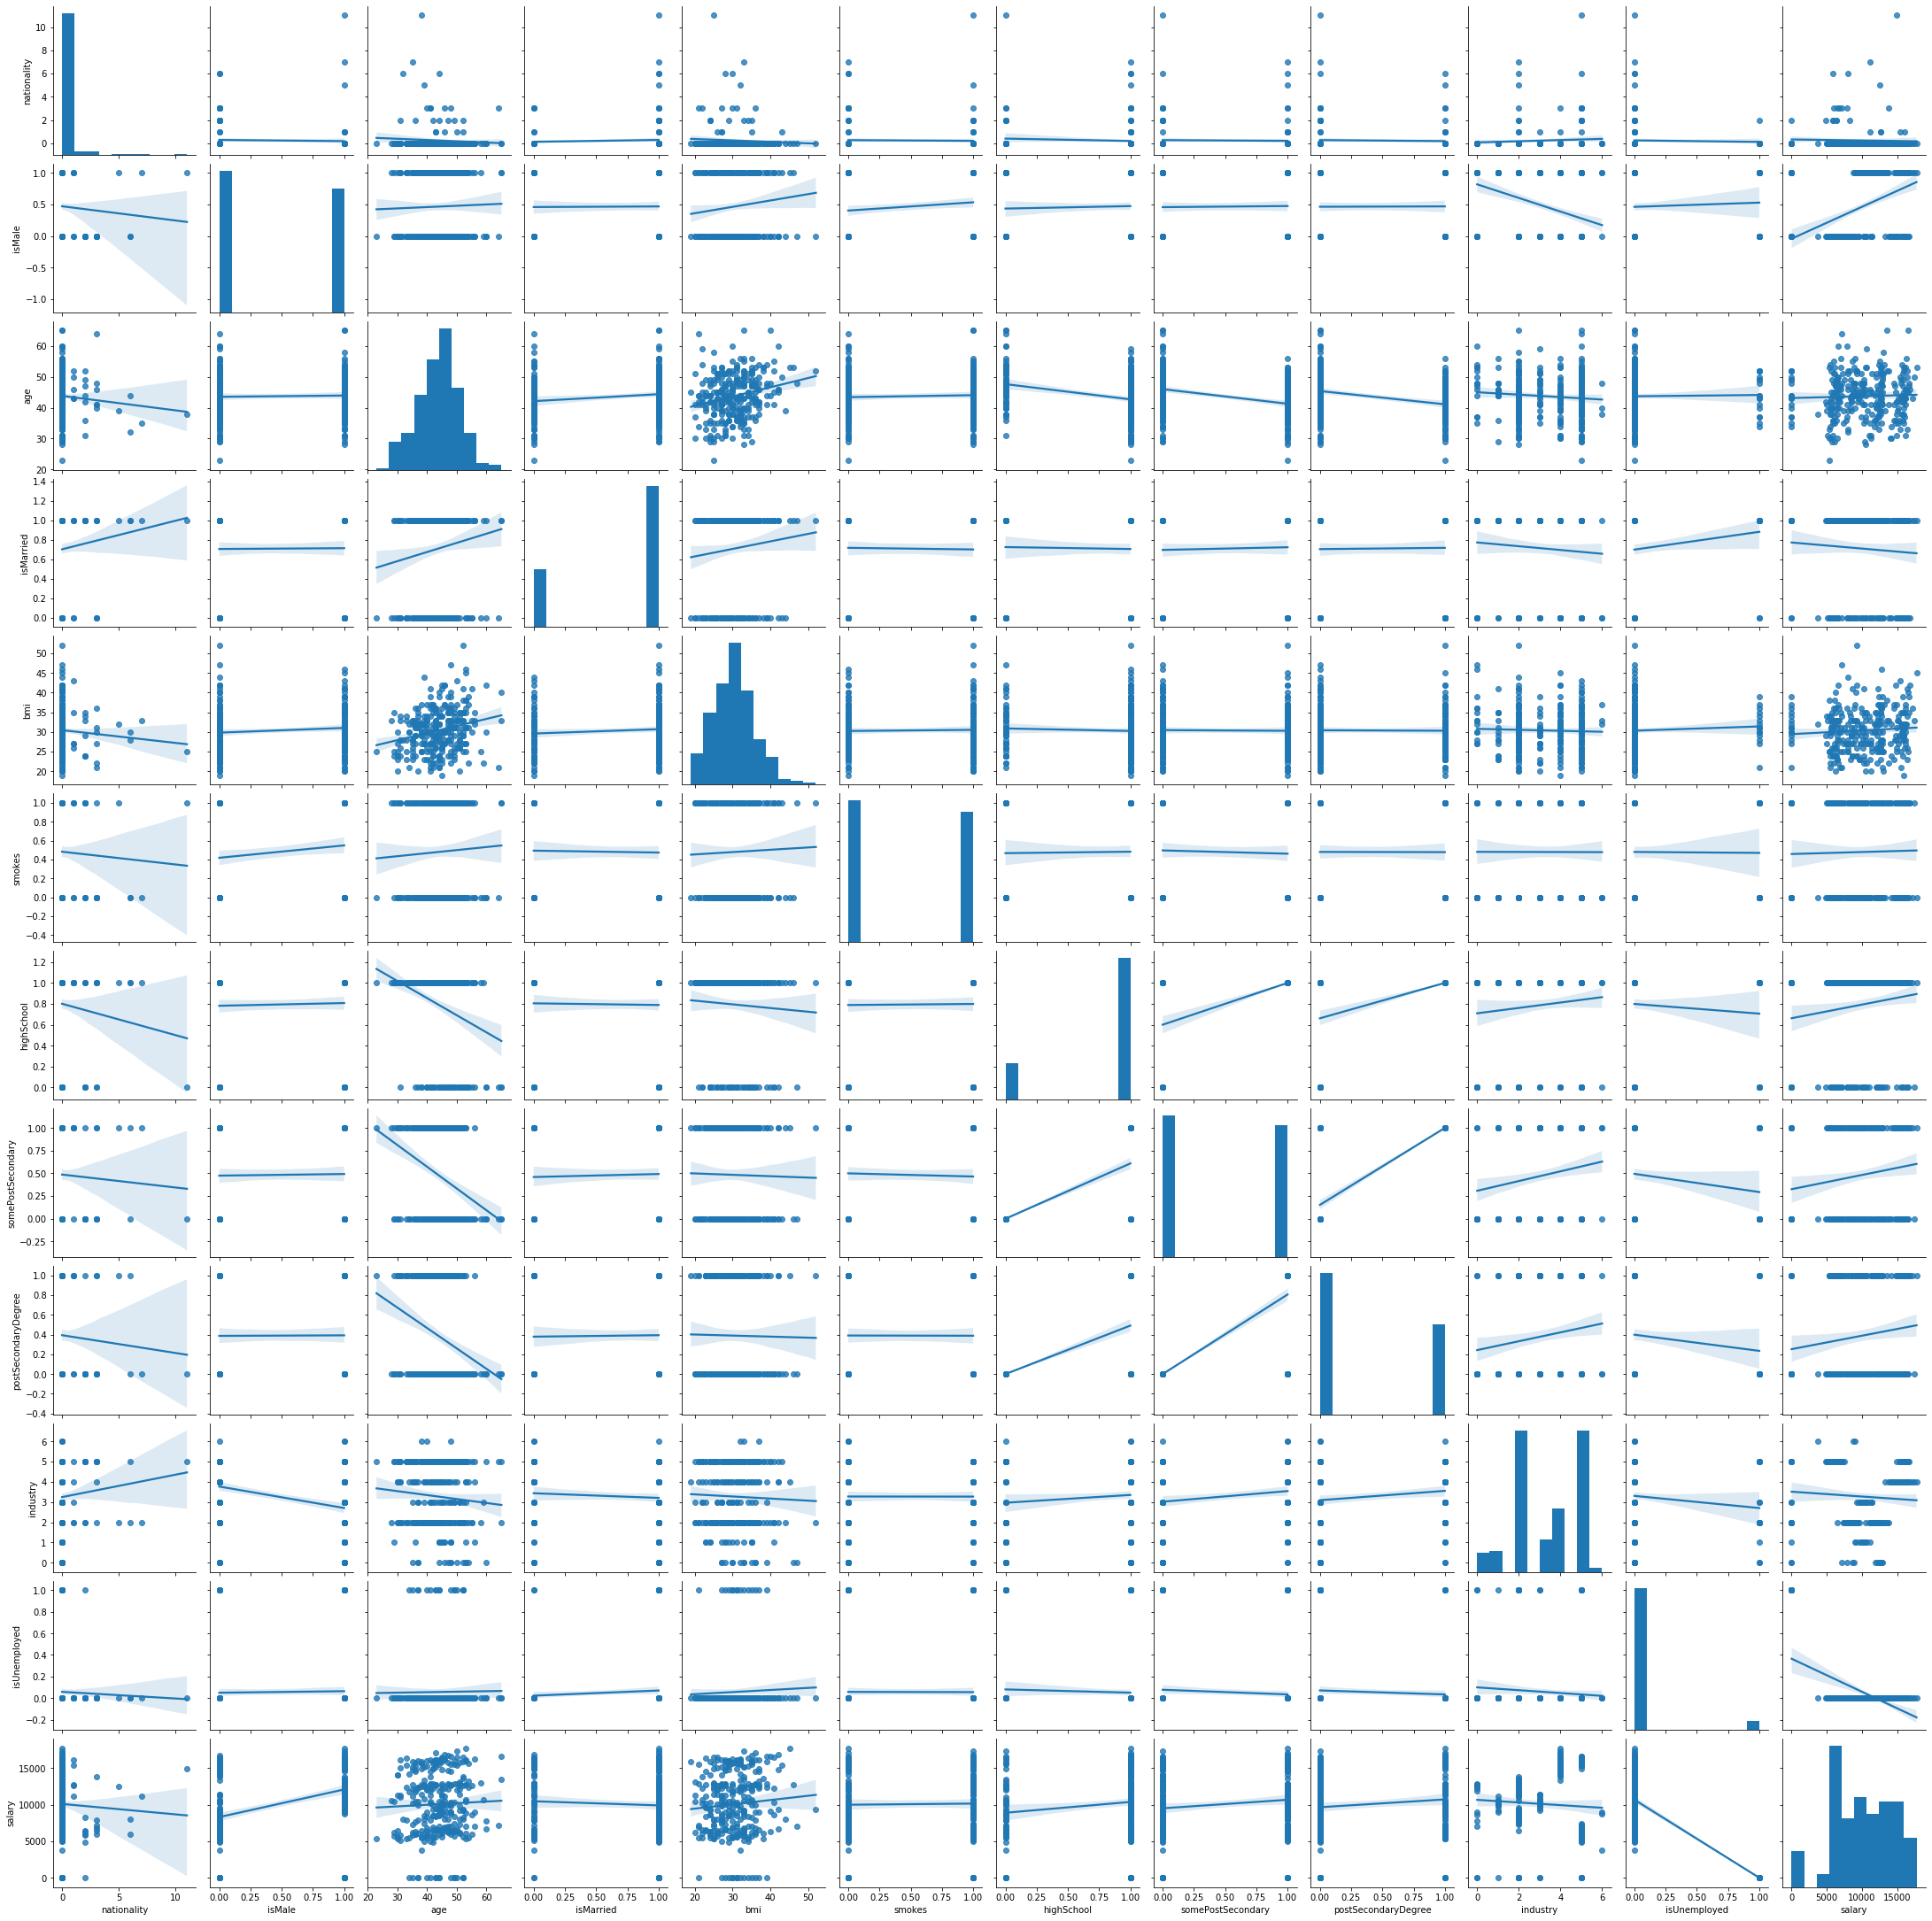

In [5]:
# visualize sample using a pairs plot, line is least squares + confidence interval 
# (don't think you can do logistic regression with pairsplot)... need to investigate
sample_pd = pd.DataFrame(sample)
sns.pairplot(sample_pd, kind='reg')
plt.show()

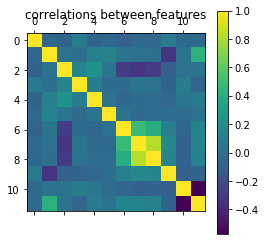

In [6]:
plt.matshow(sample_pd.corr())
plt.colorbar()
plt.title('correlations between features')
plt.show()

In [7]:
# "optimal" R^2: variance that is predictable over variance that is not predictable.

# we know predictable variance is 500^2

salary_variance = sample_pd.salary.var()

optimal_r_squared = 1 - (500**2) / salary_variance

print('salary variance: {}\nexplainable variance: {}\noptimal Rsq: {}'.format(salary_variance, 500**2, optimal_r_squared))

salary variance: 18707266.890345443
explainable variance: 250000
optimal Rsq: 0.9866362092621332


In [8]:
sample_pd.columns

Index(['nationality', 'isMale', 'age', 'isMarried', 'bmi', 'smokes',
       'highSchool', 'somePostSecondary', 'postSecondaryDegree', 'industry',
       'isUnemployed', 'salary'],
      dtype='object')

In [18]:
# Some simple models

from sklearn.linear_model import LinearRegression

X = pd.DataFrame(sample_pd[['nationality', 'isMale', 'age', 'isMarried', 'bmi', 'smokes',
       'highSchool', 'somePostSecondary', 'postSecondaryDegree', 'industry',
       'isUnemployed']])
y = pd.DataFrame(sample_pd['salary'])
add_var = pd.get_dummies(X['nationality'], prefix='nat', drop_first=True)
X = X.join(add_var)

X.drop(columns=['nationality'], inplace=True)
add_var = pd.get_dummies(X['industry'], prefix='ind', drop_first=True)
X = X.join(add_var)
X.drop(columns=['industry'], inplace=True)

model = LinearRegression()
model.fit(X, y)
rsq = model.score(X, y)
print('linear regression, all variables: Rsq = {}'.format(rsq))

linear regression, all variables: Rsq = 0.8448113735378707
